# Embedding images with CNN

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import PIL
import torch, torchvision
from pathlib import Path
from itertools import islice
import numpy as np

dir_root = Path().resolve().parent
dir_word_embedding = dir_root / "word2vec_model"
dir_caption_vectors = dir_word_embedding / "vectors"
dir_images = dir_root / "data" / "img_resized"
dir_captions = dir_root / "data" / "captions"
dir_image_vectors = dir_root / "cnn_text_supervision" / "vectors"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Data observation

/home/qfortier/.cache/pypoetry/virtualenvs/deep-learning-for-multimodal-image-retriev-gE_q2Zq3-py3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 127873 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/qfortier/.cache/pypoetry/virtualenvs/deep-learning-for-multimodal-image-retriev-gE_q2Zq3-py3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 127804 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/qfortier/.cache/pypoetry/virtualenvs/deep-learning-for-multimodal-image-retriev-gE_q2Zq3-py3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128077 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/qfortier/.cache/pypoetry/virtualenvs/deep-learning-for-multimodal-image-retriev-gE_q2Zq3-py3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 127996 missing from cur

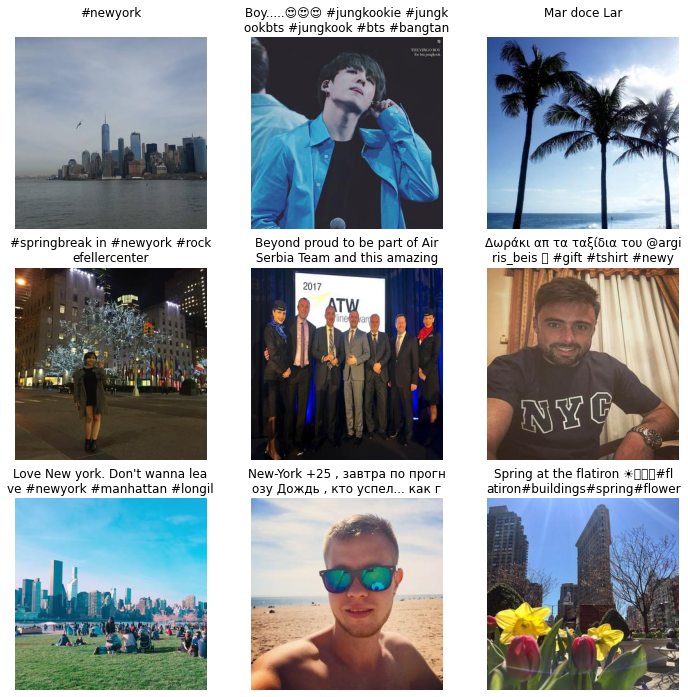

In [2]:
from itertools import islice

figure = plt.figure(figsize=(12, 12))
for i, f in enumerate(islice(dir_images.rglob("*.jpg"), 9)):
    figure.add_subplot(3, 3, i+1)
    plt.axis("off")
    caption = (dir_captions / f.relative_to(dir_images).with_suffix(".txt")).read_text()
    plt.title(caption[:30] + "\n" + caption[30:60])
    plt.imshow(PIL.Image.open(f))

## Load dataset

In [3]:
import torchvision.transforms as transforms
import PIL

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, mode): # mode is "train", "validate" or "test"
        self.dir_images = dir_images
        self.dir_target = dir_caption_vectors / mode
        self.data = [f.relative_to(self.dir_target) 
                     for f in self.dir_target.rglob("*.txt")]
        self.preprocess = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            # transforms.Resize(256), # If we want the crop to be more centered
            # transforms.CenterCrop(224), # This makes more sense for testing
            transforms.RandomCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
        ])

    def __len__(self): return len(self.data)

    def __getitem__(self, i):
        f = self.data[i]
        img = PIL.Image.open(self.dir_images / f.with_suffix(".jpg")).convert('RGB')
        caption_vector = torch.from_numpy(np.loadtxt(str(self.dir_target / f)))
        return f.stem, self.preprocess(img).float(), caption_vector.float()

In [4]:
dataset = ImageDataset("train")
print(f"Shape of an image: {dataset[0][1].shape}")
print(f"Shape of an embedded caption vector: {dataset[0][2].shape}")
ndim = dataset[0][1].shape[0]

Shape of an image: torch.Size([3, 224, 224])
Shape of an embedded caption vector: torch.Size([40])


## Use ResNet pretrained on ImageNet

Let's see some predictions of the ResNet on our images:

--2021-07-31 22:01:43--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10,23K  --.-KB/s    in 0,004s  

2021-07-31 22:01:43 (2,24 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]

validate: 17 batchs of size 12
train: 116 batchs of size 12


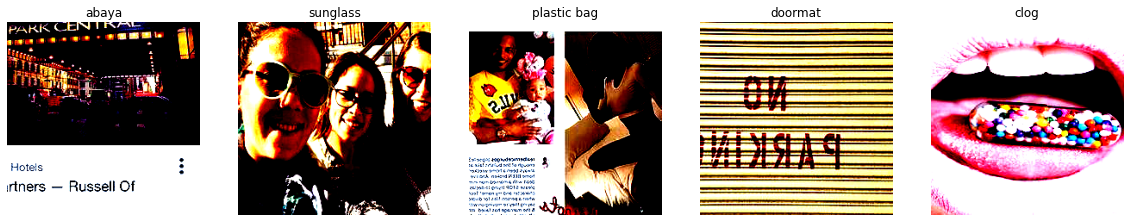

In [44]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

resnet = torchvision.models.resnet50(pretrained=True)
dataloaders = dict()
for mode in "validate", "train":
    dataloaders[mode] = torch.utils.data.DataLoader(ImageDataset(mode), batch_size=12, num_workers=8, shuffle=True, pin_memory=True)
    print(f"{mode}: {len(dataloaders[mode])} batchs of size {dataloaders[mode].batch_size}")

_, img, vector = next(iter(dataloaders["validate"]))
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(resnet(img)[0], 5)

figure = plt.figure(figsize=(20, 4))
predictions = resnet(img)
for i, p in islice(enumerate(predictions), 5):
    figure.add_subplot(1, 5, i+1)
    plt.axis("off")
    top5_prob, top5_catid = torch.topk(p, 1)
    plt.title(categories[top5_catid[0]])
    plt.imshow(img[i].permute(1, 2, 0).clip(.0, 1.))

# Model Fine-tuning

In [5]:
def train_model(model, device, criterion, optimizer, dataloaders, num_epochs=5):
    for epoch in range(1, num_epochs+1):
        print(f"\nEpoch {epoch}/{num_epochs}")
        for phase in ['validate', 'train']:
            running_loss = .0
            if phase == 'train': model.train()
            else: model.eval()
            for _, inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item()
            print(f"{phase} Loss: {running_loss / len(dataloaders[phase]):.4f}")

In [6]:
resnet = torchvision.models.resnet18(pretrained=True)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, 40) # the model should output in the word vector space
resnet = resnet.to(device)
if torch.cuda.device_count() > 1:
    resnet = torch.nn.DataParallel(resnet)

dataloaders = dict()
for mode in "validate", "train":
    dataloaders[mode] = torch.utils.data.DataLoader(ImageDataset(mode), batch_size=10, num_workers=8, shuffle=True, pin_memory=True)
    print(f"{mode}: {len(dataloaders[mode])} batchs of size {dataloaders[mode].batch_size}")
criterion = torch.nn.MSELoss(reduction='sum').to(device)
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.01)
# torch.optim.SGD(resnet.parameters(), .01, momentum=.9, weight_decay=1e-4)
train_model(resnet, device, criterion, optimizer, dataloaders, num_epochs=10)

validate: 20 batchs of size 10
train: 139 batchs of size 10

Epoch 1/10


/home/qfortier/.cache/pypoetry/virtualenvs/deep-learning-for-multimodal-image-retriev-gE_q2Zq3-py3.8/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


validate Loss: 992.7653


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [47]:
for img_name, img, _ in dataloaders["validate"]:
    vectors = model(img.to("cuda"))
    for i, v in enumerate(vectors):
        torch.save(v, dir_image_vectors / img_name[i])

TypeError: 'module' object is not callable

In [ ]:
import heapq as hq
from gensim.models import Word2Vec

word2vec = Word2Vec.load(str(dir_word_embedding / "model_captions"))
query_vector = torch.from_numpy(word2vec.wv.get_vector("food")).to("cuda")
closest = []
n_results = 5

for img_name, img, _ in dataloaders["train"]:
    vectors = resnet(img.to("cuda"))
    for i, v in enumerate(vectors):
        d = ((v - query_vector)**2).sum(axis=0).item()
        if len(closest) < n_results:
            hq.heappush(closest, (-d, id(v), img[i], v))
        elif -closest[0][0] > d:
            hq.heappushpop(closest, (-d, id(v), img[i], v))

figure = plt.figure(figsize=(20, 4))
for i, (nd, _, img, v) in enumerate(closest):
    figure.add_subplot(1, 5, i+1)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).clip(.0, 1.))
    plt.title(str(-nd))
    print(v)